# Imports

In [1]:
# Pip install
!pip install shap
!pip install xgboost
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 4.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 21.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 29.7 MB/s eta 0:00:0000:0100:01
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 11.4 MB/s eta 0:00:0000:0100:01
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.7 MB/s eta 0:00:00:00:010:01


In [2]:
# Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
import re # Renaming special JSON characters in feature names so LGBM can read it

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Regression metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
scorer = make_scorer(r2_score) # Defining the scorer used for GridSearchCV

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Model exploration
import shap

# Model saving
import pickle

pd.set_option("display.max_columns", None) # Show all columns in the dataframe

In [20]:
# Importing datasets (BL and SL datasets include player ratings scrabed from the web)
BL18 = pd.read_csv(r'/work/M3/CSV files/Bundesliga18_rating.csv', sep=",", decimal=",")
BL19 = pd.read_csv(r'/work/M3/CSV files/Bundesliga19_rating.csv', sep=",", decimal=",")
BL20 = pd.read_csv(r'/work/M3/CSV files/Bundesliga20_rating.csv', sep=",", decimal=",")
BL21 = pd.read_csv(r'/work/M3/CSV files/Bundesliga21_rating.csv', sep=",", decimal=",")
BL22 = pd.read_csv(r'/work/M3/CSV files/Bundesliga22_rating.csv', sep=",", decimal=",")
SL21 = pd.read_csv(r'/work/M3/CSV files/Superliga21_rating.csv', sep=",", decimal=",")
SL22 = pd.read_csv(r'/work/M3/CSV files/Superliga22_rating.csv', sep=",", decimal=",")

PSG = pd.read_csv(r'/work/M3/CSV files/PSG_Ligue_1_Performance.csv', sep=";", decimal=",")
MESSI = pd.read_csv(r'/work/M3/CSV files/Lionel_Messi_La_Liga_Performance.csv', sep=";", decimal=",")

# Data Cleaning

## Metrics by League

In [21]:
# Examining data structure and column names
# This step is performed on all league datasets: BL18, BL19, BL20, BL21, BL22, SL21, SL22
BL18.head()

,Player,Rating,Team,Team within selected timeframe,Position,Age,Market value,Contract expires,Matches played,Minutes played,Goals,xG,Assists,xA,Duels per 90,"Duels won, %",Birth country,Passport country,Foot,Height,Weight,On loan,Successful defensive actions per 90,Defensive duels per 90,"Defensive duels won, %",Aerial duels per 90,"Aerial duels won, %",Sliding tackles per 90,PAdj Sliding tackles,Shots blocked per 90,Interceptions per 90,PAdj Interceptions,Fouls per 90,Yellow cards,Yellow cards per 90,Red cards,Red cards per 90,Successful attacking actions per 90,Goals per 90,Non-penalty goals,Non-penalty goals per 90,xG per 90,Head goals,Head goals per 90,Shots,Shots per 90,"Shots on target, %","Goal conversion, %",Assists per 90,Crosses per 90,"Accurate crosses, %",Crosses from left flank per 90,"Accurate crosses from left flank, %",Crosses from right flank per 90,"Accurate crosses from right flank, %",Crosses to goalie box per 90,Dribbles per 90,"Successful dribbles, %",Offensive duels per 90,"Offensive duels won, %",Touches in box per 90,Progressive runs per 90,Accelerations per 90,Received passes per 90,Received long passes per 90,Fouls suffered per 90,Passes per 90,"Accurate passes, %",Forward passes per 90,"Accurate forward passes, %",Back passes per 90,"Accurate back passes, %",Lateral passes per 90,"Accurate lateral passes, %",Short / medium passes per 90,"Accurate short / medium passes, %",Long passes per 90,"Accurate long passes, %","Average pass length, m","Average long pass length, m",xA per 90,Shot assists per 90,Second assists per 90,Third assists per 90,Smart passes per 90,"Accurate smart passes, %",Key passes per 90,Passes to final third per 90,"Accurate passes to final third, %",Passes to penalty area per 90,"Accurate passes to penalty area, %",Through passes per 90,"Accurate through passes, %",Deep completions per 90,Deep completed crosses per 90,Progressive passes per 90,"Accurate progressive passes, %",Conceded goals,Conceded goals per 90,Shots against,Shots against per 90,Clean sheets,"Save rate, %",xG against,xG against per 90,Prevented goals,Prevented goals per 90,Back passes received as GK per 90,Exits per 90,Aerial duels per 90.1,Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %"
0,M. Neuer,92,Bayern München,Bayern München,GK,36,12000000,2024-06-30,26,2410,0,0.0,0,0.0,0.41,72.73,Germany,Germany,right,193,93,no,1.16,0.11,66.67,0.19,80.0,0.0,0.0,0.0,1.08,1.81,0.04,1,0.04,0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11,66.67,0.04,0.0,0.0,20.95,0.34,0.07,27.26,89.86,13.67,82.51,0.04,100.0,12.55,97.32,19.9,97.94,7.36,68.02,28.4,46.57,0.0,0.0,0.0,0.04,0.0,0.0,0.0,1.16,54.84,0.11,33.33,0.04,0.0,0.0,0.0,6.05,72.22,23,0.86,57,2.13,10,59.65,20.54,0.77,-2.46,-0.092,0.0,0.63,0.19,NaN,NaN,NaN,0.0,0,0.0
1,R. Lewandowski,91,Barcelona,Bayern München,CF,34,45000000,2026-06-30,33,3098,22,28.43,7,5.75,20.1,36.13,Poland,Poland,right,185,81,no,1.63,1.51,50.0,4.5,32.9,0.06,0.1,0.09,0.81,1.39,0.67,2,0.06,0,0.0,3.81,0.64,19,0.55,0.83,6,0.17,134,3.89,39.55,16.418,0.2,0.67,26.09,0.32,9.09,0.32,45.45,0.12,3.43,46.61,9.96,34.4,6.19,1.1,0.9,16.3,1.37,1.28,20.05,79.86,4.82,71.08,4.33,90.6,5.72,81.73,18.71,81.68,0.7,79.17,15.51,19.41,0.17,0.93,0.12,0.0,1.07,45.95,0.55,1.83,80.95,1.83,65.08,0.87,40.0,1.74,0.17,2.03,87.14,0,NaN,0,NaN,0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.15,0.15,0.0,0.0,4,75.0
2,M. Hummels,90,Borussia Dortmund,Bayern München,LCB,33,6500000,2023-06-30,21,1852,1,3.58,1,0.64,15.21,63.9,Germany,Germany,right,191,94,no,8.46,4.23,72.41,6.61,60.29,0.78,1.3,0.39,4.62,7.72,0.44,2,0.1,0,0.0,1.41,0.05,1,0.05,0.17,1,0.05,19,0.92,26.32,5.263,0.05,0.29,16.67,0.24,20.0,0.05,0.0,0.0,0.92,63.16,1.8,59.46,1.12,1.36,0.15,63.03,0.87,0.49,80.91,91.47,32.61,84.35,3.84,93.67,38.05,96.93,73.09,95.48,7.53,55.48,22.04,38.33,0.03,0.34,0.0,0.0,0.73,73.33,0.29,11.91,76.33,1.8,32.43,1.36,35.71,0.49,0.05,15.06,85.16,0,NaN,0,NaN,0,

In [22]:
# Examining data types and non-null counts
# This step is performed on all league datasets: BL18, BL19, BL20, BL21, BL22, SL21, SL22
BL18.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 116 columns):
 #    Column                                Non-Null Count  Dtype 
---   ------                                --------------  ----- 
 0    Player                                288 non-null    object
 1    Rating                                288 non-null    int64 
 2    Team                                  264 non-null    object
 3    Team within selected timeframe        288 non-null    object
 4    Position                              288 non-null    object
 5    Age                                   288 non-null    int64 
 6    Market value                          288 non-null    int64 
 7    Contract expires                      246 non-null    object
 8    Matches played                        288 non-null    int64 
 9    Minutes played                        288 non-null    int64 
 10   Goals                                 288 non-null    int64 
 11   xG               

In [23]:
# Examining missing values
# This step is performed on all league datasets: BL18, BL19, BL20, BL21, BL22, SL21, SL22
# Using a for statement to print all columns (otherwise the isnull().sum() statement only shows the top and bottom 30 columns)
obj = BL18.isnull().sum()
for key,value in obj.iteritems():
    print(value,key)

0 Player
0 Rating
24 Team
0 Team within selected timeframe
0 Position
0 Age
0 Market value
42 Contract expires
0 Matches played
0 Minutes played
0 Goals
0 xG
0 Assists
0 xA
13 Duels per 90
13 Duels won, %
0 Birth country
0 Passport country
0 Foot
0 Height
0 Weight
0 On loan
13 Successful defensive actions per 90
13 Defensive duels per 90
13 Defensive duels won, %
13 Aerial duels per 90
13 Aerial duels won, %
13 Sliding tackles per 90
0 PAdj Sliding tackles
13 Shots blocked per 90
13 Interceptions per 90
0 PAdj Interceptions
13 Fouls per 90
0 Yellow cards
13 Yellow cards per 90
0 Red cards
13 Red cards per 90
13 Successful attacking actions per 90
13 Goals per 90
0 Non-penalty goals
13 Non-penalty goals per 90
13 xG per 90
0 Head goals
13 Head goals per 90
0 Shots
13 Shots per 90
13 Shots on target, %
0 Goal conversion, %
13 Assists per 90
13 Crosses per 90
13 Accurate crosses, %
13 Crosses from left flank per 90
13 Accurate crosses from left flank, %
13 Crosses from right flank per 90


In [24]:
# From above it is suspected that certain players (rows) have NaN values in multiple columns, since the same number
# of NaN values occur in multiple columns. Players with NaN values in multiple columns are therefore dropped from the datasets

# From above it is also identified that NaN values occur in columns related to whether or not a player is a goalkeeper
# Hence these NaN values will be handled later during subsetting of datasets based on positions
# Goalkeeper columns: Conceded goals per 90, Shots against per 90, Prevented goals, Prevented goals per 90, Exits per 90, Aerial duels per 90.1 (i.e. only goalkeepers have values)
# Non-goalkeeper columns: Free kicks per 90, Direct free kicks per 90, Direct free kicks on target, % (i.e. only goalkeepers are missing values)

# Rows are dropped in the necessary datasets based on a column identified in above
BL18 = BL18.dropna(subset=['Duels per 90'])
BL19 = BL19.dropna(subset=['Duels per 90'])
BL20 = BL20.dropna(subset=['Duels per 90'])

In [25]:
# Creating a function to clean the data
def clean_data_league(df):
    cols = df.columns.drop(['Player', 'Team', 'Team within selected timeframe', 'Position', 'Contract expires', 'Birth country', 'Passport country', 'Foot', 'On loan'])
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df['Contract expires'] =  pd.to_datetime(df['Contract expires'])
    df[['Player', 'Team', 'Team within selected timeframe', 'Position', 'Contract expires', 'Birth country', 'Passport country', 'Foot', 'On loan']] = df[['Player', 'Team', 'Team within selected timeframe', 'Position', 'Contract expires', 'Birth country', 'Passport country', 'Foot', 'On loan']].fillna('Unknown')
    return df

In [26]:
# Applying the function to the data
BL18 = clean_data_league(BL18)
BL19 = clean_data_league(BL19)
BL20 = clean_data_league(BL20)
BL21 = clean_data_league(BL21)
BL22 = clean_data_league(BL22)
SL21 = clean_data_league(SL21)
SL22 = clean_data_league(SL22)

## Metrics by Player

In [27]:
# Examining data structure and column names
MESSI.head()

,Match,Competition,Date,Position,Minutes played,Total actions / successful,Unnamed: 6,Goals,Assists,Shots / on target,Unnamed: 10,xG,Passes / accurate,Unnamed: 13,Long passes / accurate,Unnamed: 15,Crosses / accurate,Unnamed: 17,Dribbles / successful,Unnamed: 19,Duels / won,Unnamed: 21,Aerial duels / won,Unnamed: 23,Interceptions,Losses / own half,Unnamed: 26,Recoveries / opp. half,Unnamed: 28,Yellow card,Red card,Defensive duels / won,Unnamed: 32,Loose ball duels / won,Unnamed: 34,Sliding tackles / successful,Unnamed: 36,Clearances,Fouls,Yellow cards,Red cards,Shot assists,Offensive duels / won,Unnamed: 43,Touches in penalty area,Offsides,Progressive runs,Fouls suffered,Through passes / accurate,Unnamed: 49,xA,Second assists,Passes to final third / accurate,Unnamed: 53,Passes to penalty area / accurate,Unnamed: 55,Received passes,Forward passes / accurate,Unnamed: 58,Back passes / accurate,Unnamed: 60,Conceded goals,xCG,Shots against,Saves / with reflexes,Unnamed: 65,Exits,Passes to GK / accurate,Unnamed: 68,Goal kicks,Short goal kicks,Long goal kicks
0,Barcelona - Celta de Vigo 1:2,Spain. LaLiga,2021-05-16,CF,94,117,76,1,0,7,2,0.84,63,53,8,5,2,0,13,7,31,15,1,0,2,15,1,3,3,0,0,2,2,0,0,0,0,0,0,0,0,4,28,13,11,0,7,1,3,1,0.69,0,9,9,6,4,50,21,17,14,14,0,0,0,0,0,0,0,0,0,0,0
1,Levante - Barcelona 3:3,Spain. LaLiga,2021-05-11,CF,95,75,47,1,0,6,1,0.42,44,35,4,2,1,1,8,4,15,7,1,0,0,5,1,5,5,0,0,0,0,1,0,0,0,0,0,0,0,2,13,7,4,1,2,3,4,2,0.29,0,5,4,6,4,36,17,12,7,6,0,0,0,0,0,0,0,0,0,0,0
2,Barcelona - Atlético Madrid 0:0,Spain. LaLiga,2021-05-08,CF,97,92,70,0,0,2,1,0.12,49,42,3,2,1,1,14,11,29,18,1,0,1,13,2,4,3,0,0,1,1,4,1,0,0,0,0,0,0,3,23,16,2,0,10,9,4,1,0.36,0,7,5,3,2,42,14,11,7,6,0,0,0,0,0,0,0,0,0,0,0
3,Valencia - Barcelona 2:3,Spain. LaLiga,2021-05-02,CF,95,125,84,2,0,5,3,1.71,81,65,5,3,2,1,4,3,21,8,0,0,2,16,2,1,1,0,0,4,3,3,1,0,0,0,1,0,0,1,14,4,4,0,4,3,2,0,0.34,0,19,14,8,7,68,28,19,11,10,0,0,0,0,0,0,0,0,0,0,0
4,Barcelona - Granada 1:2,Spain. LaLiga,2021-04-29,"AMF, CF",95,122,88,1,0,6,2,0.53,75,64,3,2,5,4,18,12,32,16,0,0,0,13,0,0,0,0,0,1,1,3,1,0,0,0,0,0,0,1,28,14,5,0,10,6,3,0,0.08,0,10,9,11,8,67,20,16,3,3,0,0,0,0,0,0,0,0,0,0,0


In [28]:
# Examining data types and non-null counts
MESSI.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 72 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Match                              205 non-null    object 
 1   Competition                        205 non-null    object 
 2   Date                               205 non-null    object 
 3   Position                           205 non-null    object 
 4   Minutes played                     205 non-null    int64  
 5   Total actions / successful         205 non-null    int64  
 6   Unnamed: 6                         205 non-null    int64  
 7   Goals                              205 non-null    int64  
 8   Assists                            205 non-null    int64  
 9   Shots / on target                  205 non-null    int64  
 10  Unnamed: 10                        205 non-null    int64  
 11  xG                                 205 non-null    float64

In [29]:
# Creating a function to clean the data
def clean_data_player(df):
    df['Date'] =  pd.to_datetime(df['Date'])
    df.rename(columns = {
        'Total actions / successful':'Total actions',
        'Unnamed: 6':'Total actions successful',
        'Shots / on target':'Shots',
        'Unnamed: 10':'Shots on target',
        'Passes / accurate':'Passes',
        'Unnamed: 13':'Passes accurate',
        'Long passes / accurate':'Long passes',
        'Unnamed: 15':'Long passes accurate',
        'Crosses / accurate':'Crosses',
        'Unnamed: 17':'Crosses accurate',
        'Dribbles / successfus':'Dribbles',
        'Unnamed: 19':'Dribbles successful',
        'Duels / won':'Duels',
        'Unnamed: 21':'Duels won',
        'Aerial duels / won':'Aerial duels',
        'Unnamed: 23':'Aerial duels won',
        'Losses / own half':'Losses',
        'Unnamed: 26':'Losses own half',
        'Recoveries / opp. half':'Recoveries',
        'Unnamed: 28':'Recoveries opp. half',
        'Defensive duels / won':'Defensive duels',
        'Unnamed: 32':'Defensive duels won',
        'Loose ball duels / won':'Loose ball duels',
        'Unnamed: 34':'Loose ball duels won',
        'Sliding tackles / successful':'Sliding tackles',
        'Unnamed: 36':'Sliding tackles successful',
        'Offensive duels / won':'Offensive duels',
        'Unnamed: 43':'Offensive duels won',
        'Through passes / accurate':'Through passes',
        'Unnamed: 49':'Through passes accurate',
        'Passes to final third / accurate':'Passes to final third',
        'Unnamed: 53':'Passes to final third accurate',
        'Passes to penalty area / accurate':'Passes to penalty area',
        'Unnamed: 55':'Passes to penalty area accurate',
        'Forward passes / accurate':'Forward passes',
        'Unnamed: 58':'Forward passes accurate',
        'Back passes / accurate':'Back passes',
        'Unnamed: 60':'Back passes accurate',
        'Saves / with reflexes':'Saves',
        'Unnamed: 65':'Saves with reflexes',
        'Passes to GK / accurate':'Passes to GK',
        'Unnamed: 68':'Passes to GK accurate'
        }, inplace = True)
    return df

In [30]:
# Applying the function to the data
MESSI = clean_data_player(MESSI)

## Metrics by Game

In [31]:
# Examining data structure and column names
PSG.head()

,Date,Match,Competition,Duration,Team,Scheme,Goals,xG,Shots / on target,Unnamed: 9,Unnamed: 10,Passes / accurate,Unnamed: 12,Unnamed: 13,"Possession, %",Losses / Low / Medium / High,Unnamed: 16,Unnamed: 17,Unnamed: 18,Recoveries / Low / Medium / High,Unnamed: 20,Unnamed: 21,Unnamed: 22,Duels / won,Unnamed: 24,Unnamed: 25,Shots from outside penalty area / on target,Unnamed: 27,Unnamed: 28,Positional attacks / with shots,Unnamed: 30,Unnamed: 31,Counterattacks / with shots,Unnamed: 33,Unnamed: 34,Set pieces / with shots,Unnamed: 36,Unnamed: 37,Corners / with shots,Unnamed: 39,Unnamed: 40,Free kicks / with shots,Unnamed: 42,Unnamed: 43,Penalties / converted,Unnamed: 45,Unnamed: 46,Crosses / accurate,Unnamed: 48,Unnamed: 49,Deep completed crosses,Deep completed passes,Penalty area entries (runs / crosses),Unnamed: 53,Unnamed: 54,Touches in penalty area,Offensive duels / won,Unnamed: 57,Unnamed: 58,Offsides,Conceded goals,Shots against / on target,Unnamed: 62,Unnamed: 63,Defensive duels / won,Unnamed: 65,Unnamed: 66,Aerial duels / won,Unnamed: 68,Unnamed: 69,Sliding tackles / successful,Unnamed: 71,Unnamed: 72,Interceptions,Clearances,Fouls,Yellow cards,Red cards,Forward passes / accurate,Unnamed: 79,Unnamed: 80,Back passes / accurate,Unnamed: 82,Unnamed: 83,Lateral passes / accurate,Unnamed: 85,Unnamed: 86,Long passes / accurate,Unnamed: 88,Unnamed: 89,Passes to final third / accurate,Unnamed: 91,Unnamed: 92,Progressive passes / accurate,Unnamed: 94,Unnamed: 95,Smart passes / accurate,Unnamed: 97,Unnamed: 98,Throw ins / accurate,Unnamed: 100,Unnamed: 101,Goal kicks,Match tempo,Average passes per possession,Long pass %,Average shot distance,Average pass length,PPDA
0,PSG,NaN,NaN,NaN,NaN,NaN,2.47,2.22,15.18,6.47,42.63,656.45,596.76,90.91,62.07,81.45,14.16,23.63,43.66,68.55,27.05,27.79,13.71,178.37,87.58,49.10,5.05,1.34,26.56,33.84,8.82,26.05,2.55,1.16,45.36,25.53,4.05,15.88,5.50,1.89,34.45,1.74,0.32,18.18,0.26,0.21,80.0,9.89,3.58,36.17,3.37,15.08,29.16,5.55,5.45,26.11,77.47,33.16,42.80,2.58,0.87,10.11,3.92,38.80,59.47,36.03,60.58,15.45,8.16,52.81,4.66,2.32,49.72,34.34,8.71,9.21,2.16,0.11,182.61,155.76,85.30,98.45,93.39,94.87,253.61,239.18,94.31,27.63,17.45,63.14,66.95,57.58,86.01,72.26,57.63,79.75,12.03,5.16,42.89,15.66,14.97,95.63,6.50,18.66,7.01,4.24,17.04,16.69,10.16
1,Opponents,NaN,NaN,NaN,NaN,NaN,0.87,1.11,10.11,3.71,36.72,380.26,325.18,85.52,37.93,80.18,18.97,28.89,32.32,61.58,32.92,19.92,8.74,178.37,85.61,47.99,4.71,1.26,26.82,22.13,6.05,27.35,3.53,1.32,37.31,22.45,2.34,10.43,3.55,0.84,23.70,1.45,0.29,20.00,0.11,0.08,75.0,10.45,3.55,34.01,3.45,4.87,17.97,3.92,6.13,13.42,59.47,23.45,39.42,1.95,2.47,15.18,6.71,44.19,77.47,44.29,57.17,15.45,6.58,42.59,4.68,2.21,47.19,40.71,12.92,11.84,1.82,0.11,118.11,90.68,76.78,58.61,55.32,94.39,134.32,119.61,89.05,33.05,20.03,60.59,39.45,28.42,72.05,53.66,35.76,66.65,5.21,1.45,27.78,12.16,11.55,95.02,8.61,17.54,4.37,8.99,19.82,18.07,18.86
2,2022-09-18,Olympique Lyonnais - PSG 0:1,France. Ligue 1,94.0,PSG,3-4-3 (100.0%),1.00,2.10,14.00,8.00,57.14,773.00,717.00,92.76,64.21,91.00,18.00,30.00,43.00,75.00,39.00,24.00,12.00,192.00,89.00,46.35,2.00,2.00,100.00,32.00,7.00,21.88,1.00,1.00,100.00,31.00,5.00,16.13,7.00,1.00,14.29,1.00,0.00,0.00,0.00,0.00,0.0,6.00,1.00,16.67,1.00,16.00,28.00,11.00,2.00,31.00,101.00,38.00,37.62,3.00,0.00,12.00,3.00,25.00,59.00,35.00,59.32,12.00,8.00,66.67,3.00,1.00,33.33,42.00,6.00,4.00,2.00,0.00,195.00,167.00,85.64,122.00,120.00,98.36,292.00,280.00,95.89,36.00,21.00,58.33,77.00,66.00,85.71,80.00,57.00,71.25,8.00,3.00,37.50,11.00,10.00,90.91,7.00,19.50,7.97,4.66,15.32,16.35,13.35
3,2022-09-18,Olympique Lyonnais - PSG 0:1,France. Ligue 1,94.0,Olympique Lyonnais,4-4-2 (100.0%),0.00,1.46,12.00,3.00,25.00,430.00,367.00,85.35,35.79,83.00,17.00,25.00,41.00,68.00,31.00,22.00,15.00,192.00,98.00,51.04,2.00,0.00,0.00,34.00,10.00,29.41,0.00,0.00,0.00,13.00,2.00,15.38,3.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.0,16.00,6.00,37.50,6.00,12.00,32.00,6.00,12.00,25.00,59.00,24.00,40.68,3.00,

In [32]:
# Examining data types and non-null counts
PSG.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 109 columns):
 #    Column                                       Non-Null Count  Dtype  
---   ------                                       --------------  -----  
 0    Date                                         78 non-null     object 
 1    Match                                        76 non-null     object 
 2    Competition                                  76 non-null     object 
 3    Duration                                     76 non-null     float64
 4    Team                                         76 non-null     object 
 5    Scheme                                       76 non-null     object 
 6    Goals                                        78 non-null     float64
 7    xG                                           78 non-null     float64
 8    Shots / on target                            78 non-null     float64
 9    Unnamed: 9                                   78 non-null     floa

In [33]:
# Creating a function to clean the first two rows of the data
# Note that the first two rows contain averages of all matches, i.e. these are handled separately
def clean_data_team_avg(df):
    df = df.drop(df.index[2:])
    df = df.dropna(axis = 1)
    df.rename(columns = {
        'Date':'Team',
        'Shots / on target':'Shots',
        'Unnamed: 9':'Shots on target',
        'Unnamed: 10':'Shots on target, %',
        'Passes / accurate':'Passes',
        'Unnamed: 12':'Passes acurate',
        'Unnamed: 13':'Passes accurate, %',
        'Losses / Low / Medium / High':'Losses',
        'Unnamed: 16':'Losses low',
        'Unnamed: 17':'Losses medium',
        'Unnamed: 18':'Losses high',
        'Recoveries / Low / Medium / High':'Recoveries',
        'Unnamed: 20':'Recoveries low',
        'Unnamed: 21':'Recoveries medium',
        'Unnamed: 22':'Recoveries High',
        'Duels / won':'Duels',
        'Unnamed: 24':'Duels won',
        'Unnamed: 25':'Duels won, %',
        'Shots from outside penalty area / on target':'Shots from outside penalty area',
        'Unnamed: 27':'Shots from outside penalty area / on target',
        'Unnamed: 28':'Shots from outside penalty area / on target, %',
        'Positional attacks / with shots':'Positional attacks',
        'Unnamed: 30':'Positional attacks with shots',
        'Unnamed: 31':'Positional attacks with shots, %',
        'Counterattacks / with shots':'Counterattacks',
        'Unnamed: 33':'Counterattacks with shots',
        'Unnamed: 34':'Counterattacks / with shots, %',
        'Set pieces / with shots':'Set pieces',
        'Unnamed: 36':'Set pieces with shots',
        'Unnamed: 37':'Set pieces with shots, %',
        'Corners / with shots':'Corners',
        'Unnamed: 39':'Corners with shots',
        'Unnamed: 40':'Corners with shots, %',
        'Free kicks / with shots':'Free kicks',
        'Unnamed: 42':'Free kicks with shots',
        'Unnamed: 43':'Free kicks with shots, %',
        'Penalties / converted':'Penalties',
        'Unnamed: 45':'Penalties converted',
        'Unnamed: 46':'Penalties converted, %',
        'Crosses / accurate':'Crosses',
        'Unnamed: 48':'Crosses accurate',
        'Unnamed: 49':'Crosses accurate, %',
        'Penalty area entries (runs / crosses)':'Penalty area entries',
        'Unnamed: 53':'Penalty area entries (runs)',
        'Unnamed: 54':'Penalty area entries (crosses)',
        'Offensive duels / won':'Offensive duels',
        'Unnamed: 57':'Offensive duels won',
        'Unnamed: 58':'Offensive duels won, %',
        'Shots against / on target':'Shots against',
        'Unnamed: 62':'Shots against on target',
        'Unnamed: 63':'Shots against on target, %',
        'Defensive duels / won':'Defensive duels',
        'Unnamed: 65':'Defensive duels won',
        'Unnamed: 66':'Defensive duels won, %',
        'Aerial duels / won':'Aerial duels',
        'Unnamed: 68':'Aerial duels won',
        'Unnamed: 69':'Aerial duels won, %',
        'Sliding tackles / successful':'Sliding tackles',
        'Unnamed: 71':'Sliding tackles successful',
        'Unnamed: 72':'Sliding tackles successful, %',
        'Forward passes / accurate':'Forward passes',
        'Unnamed: 79':'Forward passes accurate',
        'Unnamed: 80':'Forward passes accurate, %',
        'Back passes / accurate':'Back passes',
        'Unnamed: 82':'Back passes accurate',
        'Unnamed: 83':'Back passes accurate, %',
        'Lateral passes / accurate':'Lateral passes',
        'Unnamed: 85':'Lateral passes accurate',
        'Unnamed: 86':'Lateral passes accurate, %',
        'Long passes / accurat':'Long passes',
        'Unnamed: 88':'Long passes accurate',
        'Unnamed: 89':'Long passes accurate, %',
        'Passes to final third / accurate':'Passes to final third',
        'Unnamed: 91':'Passes to final third accurate',
        'Unnamed: 92':'Passes to final third accurate, %',
        'Progressive passes / accurate':'Progressive passes',
        'Unnamed: 94':'Progressive passes accurate',
        'Unnamed: 95':'Progressive passes accurate, %',
        'Smart passes / accurate':'Smart passes',
        'Unnamed: 97':'Smart passes accurate',
        'Unnamed: 98':'Smart passes accurate, %',
        'Throw ins / accurate':'Throw ins',
        'Unnamed: 100':'Throw ins accurate',
        'Unnamed: 101':'Throw ins accurate, %'
        }, inplace = True)
    return df

In [34]:
# Creating a function to clean the data (excluding the first two rows)
# Note that the first two rows contain averages of all matches, i.e. these are handled separately
def clean_data_team(df):
    df = df.drop(df.index[:2])
    df['Date'] =  pd.to_datetime(df['Date'])
    df.rename(columns = {
        'Shots / on target':'Shots',
        'Unnamed: 9':'Shots on target',
        'Unnamed: 10':'Shots on target, %',
        'Passes / accurate':'Passes',
        'Unnamed: 12':'Passes acurate',
        'Unnamed: 13':'Passes accurate, %',
        'Losses / Low / Medium / High':'Losses',
        'Unnamed: 16':'Losses low',
        'Unnamed: 17':'Losses medium',
        'Unnamed: 18':'Losses high',
        'Recoveries / Low / Medium / High':'Recoveries',
        'Unnamed: 20':'Recoveries low',
        'Unnamed: 21':'Recoveries medium',
        'Unnamed: 22':'Recoveries High',
        'Duels / won':'Duels',
        'Unnamed: 24':'Duels won',
        'Unnamed: 25':'Duels won, %',
        'Shots from outside penalty area / on target':'Shots from outside penalty area',
        'Unnamed: 27':'Shots from outside penalty area / on target',
        'Unnamed: 28':'Shots from outside penalty area / on target, %',
        'Positional attacks / with shots':'Positional attacks',
        'Unnamed: 30':'Positional attacks with shots',
        'Unnamed: 31':'Positional attacks with shots, %',
        'Counterattacks / with shots':'Counterattacks',
        'Unnamed: 33':'Counterattacks with shots',
        'Unnamed: 34':'Counterattacks / with shots, %',
        'Set pieces / with shots':'Set pieces',
        'Unnamed: 36':'Set pieces with shots',
        'Unnamed: 37':'Set pieces with shots, %',
        'Corners / with shots':'Corners',
        'Unnamed: 39':'Corners with shots',
        'Unnamed: 40':'Corners with shots, %',
        'Free kicks / with shots':'Free kicks',
        'Unnamed: 42':'Free kicks with shots',
        'Unnamed: 43':'Free kicks with shots, %',
        'Penalties / converted':'Penalties',
        'Unnamed: 45':'Penalties converted',
        'Unnamed: 46':'Penalties converted, %',
        'Crosses / accurate':'Crosses',
        'Unnamed: 48':'Crosses accurate',
        'Unnamed: 49':'Crosses accurate, %',
        'Penalty area entries (runs / crosses)':'Penalty area entries',
        'Unnamed: 53':'Penalty area entries (runs)',
        'Unnamed: 54':'Penalty area entries (crosses)',
        'Offensive duels / won':'Offensive duels',
        'Unnamed: 57':'Offensive duels won',
        'Unnamed: 58':'Offensive duels won, %',
        'Shots against / on target':'Shots against',
        'Unnamed: 62':'Shots against on target',
        'Unnamed: 63':'Shots against on target, %',
        'Defensive duels / won':'Defensive duels',
        'Unnamed: 65':'Defensive duels won',
        'Unnamed: 66':'Defensive duels won, %',
        'Aerial duels / won':'Aerial duels',
        'Unnamed: 68':'Aerial duels won',
        'Unnamed: 69':'Aerial duels won, %',
        'Sliding tackles / successful':'Sliding tackles',
        'Unnamed: 71':'Sliding tackles successful',
        'Unnamed: 72':'Sliding tackles successful, %',
        'Forward passes / accurate':'Forward passes',
        'Unnamed: 79':'Forward passes accurate',
        'Unnamed: 80':'Forward passes accurate, %',
        'Back passes / accurate':'Back passes',
        'Unnamed: 82':'Back passes accurate',
        'Unnamed: 83':'Back passes accurate, %',
        'Lateral passes / accurate':'Lateral passes',
        'Unnamed: 85':'Lateral passes accurate',
        'Unnamed: 86':'Lateral passes accurate, %',
        'Long passes / accurat':'Long passes',
        'Unnamed: 88':'Long passes accurate',
        'Unnamed: 89':'Long passes accurate, %',
        'Passes to final third / accurate':'Passes to final third',
        'Unnamed: 91':'Passes to final third accurate',
        'Unnamed: 92':'Passes to final third accurate, %',
        'Progressive passes / accurate':'Progressive passes',
        'Unnamed: 94':'Progressive passes accurate',
        'Unnamed: 95':'Progressive passes accurate, %',
        'Smart passes / accurate':'Smart passes',
        'Unnamed: 97':'Smart passes accurate',
        'Unnamed: 98':'Smart passes accurate, %',
        'Throw ins / accurate':'Throw ins',
        'Unnamed: 100':'Throw ins accurate',
        'Unnamed: 101':'Throw ins accurate, %'
        }, inplace = True)
    return df

In [35]:
# Applying the function to the data
PSG_avg = clean_data_team_avg(PSG)
PSG = clean_data_team(PSG)

# Exploratory Data Analysis

## Metrics by League

In [36]:
# Examining dataframe shapes
print('BUNDESLIGA')
print('BL18 shape: ' + str(BL18.shape))
print('BL19 shape: ' + str(BL19.shape))
print('BL20 shape: ' + str(BL20.shape))
print('BL21 shape: ' + str(BL21.shape))
print('BL22 shape: ' + str(BL22.shape))
print('')
print('SUPERLIGA')
print('SL21 shape: ' + str(SL21.shape))
print('SL22 shape: ' + str(SL22.shape))

BUNDESLIGA
BL18 shape: (275, 116)
BL19 shape: (271, 116)
BL20 shape: (391, 116)
BL21 shape: (250, 116)
BL22 shape: (286, 116)

SUPERLIGA
SL21 shape: (114, 116)
SL22 shape: (166, 116)


In [37]:
# Describing the data
BL21.describe()

,Rating,Age,Market value,Matches played,Minutes played,Goals,xG,Assists,xA,Duels per 90,"Duels won, %",Height,Weight,Successful defensive actions per 90,Defensive duels per 90,"Defensive duels won, %",Aerial duels per 90,"Aerial duels won, %",Sliding tackles per 90,PAdj Sliding tackles,Shots blocked per 90,Interceptions per 90,PAdj Interceptions,Fouls per 90,Yellow cards,Yellow cards per 90,Red cards,Red cards per 90,Successful attacking actions per 90,Goals per 90,Non-penalty goals,Non-penalty goals per 90,xG per 90,Head goals,Head goals per 90,Shots,Shots per 90,"Shots on target, %","Goal conversion, %",Assists per 90,Crosses per 90,"Accurate crosses, %",Crosses from left flank per 90,"Accurate crosses from left flank, %",Crosses from right flank per 90,"Accurate crosses from right flank, %",Crosses to goalie box per 90,Dribbles per 90,"Successful dribbles, %",Offensive duels per 90,"Offensive duels won, %",Touches in box per 90,Progressive runs per 90,Accelerations per 90,Received passes per 90,Received long passes per 90,Fouls suffered per 90,Passes per 90,"Accurate passes, %",Forward passes per 90,"Accurate forward passes, %",Back passes per 90,"Accurate back passes, %",Lateral passes per 90,"Accurate lateral passes, %",Short / medium passes per 90,"Accurate short / medium passes, %",Long passes per 90,"Accurate long passes, %","Average pass length, m","Average long pass length, m",xA per 90,Shot assists per 90,Second assists per 90,Third assists per 90,Smart passes per 90,"Accurate smart passes, %",Key passes per 90,Passes to final third per 90,"Accurate passes to final third, %",Passes to penalty area per 90,"Accurate passes to penalty area, %",Through passes per 90,"Accurate through passes, %",Deep completions per 90,Deep completed crosses per 90,Progressive passes per 90,"Accurate progressive passes, %",Conceded goals,Conceded goals per 90,Shots against,Shots against per 90,Clean sheets,"Save rate, %",xG against,xG against per 90,Prevented goals,Prevented goals per 90,Back passes received as GK per 90,Exits per 90,Aerial duels per 90.1,Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %"
count,250.000000,250.000000,2.500000e+02,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.00000,250.00000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,23.000000,250.000000,23.000000,250.000000,250.000000,250.000000,250.00000,23.000000,23.000000,250.000000,23.000000,23.000000,227.000000,227.000000,227.000000,250.000000,250.000000,250.000000
mean,76.112000,27.248000,1.144440e+07,23.336000,1719.360000,2.396000,2.446680,1.616000,1.532600,17.699320,50.802680,184.296000,79.27200,7.668760,5.563200,56.637680,3.189120,47.11196,0.401040,0.499320,0.23388,3.975280,4.978800,1.099160,2.816000,0.159240,0.096000,0.007200,2.194680,0.126480,2.164000,0.116160,0.131720,0.468000,0.025120,18.404000,0.995360,32.456320,9.773316,0.076400,1.324240,30.672080,0.561280,23.916680,0.748040,27.806560,0.156800,2.152960,52.541640,5.46508,45.080200,1.575320,1.25768,0.734800,27.437520,1.164240,1.017160,39.043360,81.419840,12.932080,70.339440,5.80744,85.175960,14.732240,85.679440,33.71

In [38]:
# Describing the data
BL22.describe()

,Rating,Age,Market value,Matches played,Minutes played,Goals,xG,Assists,xA,Duels per 90,"Duels won, %",Height,Weight,Successful defensive actions per 90,Defensive duels per 90,"Defensive duels won, %",Aerial duels per 90,"Aerial duels won, %",Sliding tackles per 90,PAdj Sliding tackles,Shots blocked per 90,Interceptions per 90,PAdj Interceptions,Fouls per 90,Yellow cards,Yellow cards per 90,Red cards,Red cards per 90,Successful attacking actions per 90,Goals per 90,Non-penalty goals,Non-penalty goals per 90,xG per 90,Head goals,Head goals per 90,Shots,Shots per 90,"Shots on target, %","Goal conversion, %",Assists per 90,Crosses per 90,"Accurate crosses, %",Crosses from left flank per 90,"Accurate crosses from left flank, %",Crosses from right flank per 90,"Accurate crosses from right flank, %",Crosses to goalie box per 90,Dribbles per 90,"Successful dribbles, %",Offensive duels per 90,"Offensive duels won, %",Touches in box per 90,Progressive runs per 90,Accelerations per 90,Received passes per 90,Received long passes per 90,Fouls suffered per 90,Passes per 90,"Accurate passes, %",Forward passes per 90,"Accurate forward passes, %",Back passes per 90,"Accurate back passes, %",Lateral passes per 90,"Accurate lateral passes, %",Short / medium passes per 90,"Accurate short / medium passes, %",Long passes per 90,"Accurate long passes, %","Average pass length, m","Average long pass length, m",xA per 90,Shot assists per 90,Second assists per 90,Third assists per 90,Smart passes per 90,"Accurate smart passes, %",Key passes per 90,Passes to final third per 90,"Accurate passes to final third, %",Passes to penalty area per 90,"Accurate passes to penalty area, %",Through passes per 90,"Accurate through passes, %",Deep completions per 90,Deep completed crosses per 90,Progressive passes per 90,"Accurate progressive passes, %",Conceded goals,Conceded goals per 90,Shots against,Shots against per 90,Clean sheets,"Save rate, %",xG against,xG against per 90,Prevented goals,Prevented goals per 90,Back passes received as GK per 90,Exits per 90,Aerial duels per 90.1,Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %"
count,286.000000,286.000000,2.860000e+02,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,23.000000,286.000000,23.000000,286.000000,286.000000,286.000000,286.000000,23.000000,23.000000,286.000000,23.000000,23.000000,263.000000,263.000000,263.000000,286.000000,286.000000,286.000000
mean,75.461538,26.332168,9.831469e+06,22.629371,1614.031469,2.251748,2.276748,1.597902,1.518916,18.581993,51.237902,183.706294,78.538462,7.696713,5.760490,58.357343,3.346853,48.069056,0.400315,0.529441,0.242308,3.843252,5.105420,1.079965,2.734266,0.165420,0.066434,0.003287,2.180210,0.138147,2.125874,0.132378,0.138566,0.402098,0.026084,18.118881,1.083636,30.336469,9.498801,0.083531,1.239161,30.191713,0.536678,24.008112,0.691119,26.718007,0.150070,2.183566,51.482133,5.680664,44.021818,1.645909,1.143007,0.621503,24.980210,1.108741,0.960280,36.297448,79.814371,12.447692,68.776084,5.448042,85.865070,12.7765

In [39]:
# Creating a function to examine the data
def eda_league(df):
    print('No. of teams: ' + str(df['Team'].nunique()))
    print('Teams with most counts:')
    print(df['Team'].value_counts().nlargest(5))
    print('')

    print('No. of teams within selected timeframe: ' + str(df['Team within selected timeframe'].nunique()))
    print('Teams within selected timeframe with most counts:')
    print(df['Team within selected timeframe'].value_counts().nlargest(5))
    print('')

    print('No. of birth countries: ' + str(df['Birth country'].nunique()))
    print('Birth countries with most counts:')
    print(df['Birth country'].value_counts().nlargest(5))
    print('')

    print('No. of passport countries: ' + str(df['Passport country'].nunique()))
    print('Passport countries with most counts:')
    print(df['Passport country'].value_counts().nlargest(5))
    print('')

    print('Foot Distribution')
    print(df['Foot'].value_counts(normalize = True))
    return

In [40]:
# Applying the function
eda_league(BL18)

No. of teams: 117
Teams with most counts:
Unknown       22
Freiburg      12
RB Leipzig    11
Augsburg      11
Hoffenheim    11
Name: Team, dtype: int64

No. of teams within selected timeframe: 18
Teams within selected timeframe with most counts:
Freiburg             20
Schalke 04           20
Augsburg             19
Borussia Dortmund    18
Hoffenheim           17
Name: Team within selected timeframe, dtype: int64

No. of birth countries: 43
Birth countries with most counts:
Germany           142
France             20
Austria            17
Switzerland        13
Czech Republic      6
Name: Birth country, dtype: int64

No. of passport countries: 96
Passport countries with most counts:
Germany            104
Austria             16
Switzerland          8
Germany, Turkey      8
France               5
Name: Passport country, dtype: int64

Foot Distribution
right    0.778182
left     0.218182
both     0.003636
Name: Foot, dtype: float64


In [41]:
# Applying the function
eda_league(BL19)

No. of teams: 108
Teams with most counts:
Freiburg          15
Hoffenheim        12
Augsburg          11
Bayern München    11
RB Leipzig        10
Name: Team, dtype: int64

No. of teams within selected timeframe: 18
Teams within selected timeframe with most counts:
Werder Bremen        25
Freiburg             21
Hertha BSC           20
Borussia Dortmund    19
RB Leipzig           18
Name: Team within selected timeframe, dtype: int64

No. of birth countries: 41
Birth countries with most counts:
Germany        136
Austria         20
France          19
Switzerland     11
Netherlands      8
Name: Birth country, dtype: int64

No. of passport countries: 91
Passport countries with most counts:
Germany            102
Austria             17
Germany, Turkey      8
Switzerland          7
Netherlands          5
Name: Passport country, dtype: int64

Foot Distribution
right    0.789668
left     0.206642
both     0.003690
Name: Foot, dtype: float64


In [42]:
# Applying the function
eda_league(BL20)

No. of teams: 130
Teams with most counts:
Freiburg               17
Augsburg               17
Borussia Dortmund      16
Borussia M'gladbach    16
Bayer Leverkusen       16
Name: Team, dtype: int64

No. of teams within selected timeframe: 18
Teams within selected timeframe with most counts:
Hertha BSC      26
Hoffenheim      25
Union Berlin    25
Stuttgart       25
Schalke 04      25
Name: Team within selected timeframe, dtype: int64

No. of birth countries: 48
Birth countries with most counts:
Germany        185
France          30
Austria         27
Netherlands     16
Switzerland     14
Name: Birth country, dtype: int64

No. of passport countries: 128
Passport countries with most counts:
Germany        129
Austria         23
Switzerland      8
Netherlands      7
Japan            7
Name: Passport country, dtype: int64

Foot Distribution
right    0.782609
left     0.214834
both     0.002558
Name: Foot, dtype: float64


In [43]:
# Applying the function
eda_league(BL21)

No. of teams: 46
Teams with most counts:
Augsburg             18
Hoffenheim           17
Hertha BSC           16
Bayer Leverkusen     16
Borussia Dortmund    15
Name: Team, dtype: int64

No. of teams within selected timeframe: 18
Teams within selected timeframe with most counts:
Hoffenheim          21
Augsburg            20
Stuttgart           17
Bayer Leverkusen    17
Union Berlin        16
Name: Team within selected timeframe, dtype: int64

No. of birth countries: 38
Birth countries with most counts:
Germany        122
France          19
Austria         18
Switzerland     10
Belgium          9
Name: Birth country, dtype: int64

No. of passport countries: 92
Passport countries with most counts:
Germany        90
Austria        16
Switzerland     6
Japan           5
Poland          4
Name: Passport country, dtype: int64

Foot Distribution
right    0.78
left     0.22
Name: Foot, dtype: float64


In [44]:
# Applying the function
eda_league(BL22)

No. of teams: 32
Teams with most counts:
Union Berlin         21
Augsburg             20
Bayer Leverkusen     20
Wolfsburg            19
Borussia Dortmund    18
Name: Team, dtype: int64

No. of teams within selected timeframe: 18
Teams within selected timeframe with most counts:
Bayer Leverkusen    21
Wolfsburg           21
Freiburg            21
Köln                20
Hoffenheim          19
Name: Team within selected timeframe, dtype: int64

No. of birth countries: 42
Birth countries with most counts:
Germany        146
France          20
Austria         17
Denmark         11
Netherlands     10
Name: Birth country, dtype: int64

No. of passport countries: 93
Passport countries with most counts:
Germany        111
Austria         16
Denmark          8
Switzerland      6
Netherlands      6
Name: Passport country, dtype: int64

Foot Distribution
right    0.748252
left     0.248252
both     0.003497
Name: Foot, dtype: float64


In [45]:
# Applying the function
eda_league(SL21)

No. of teams: 33
Teams with most counts:
Randers         14
AGF             11
Nordsjælland    11
Brøndby          9
AaB              9
Name: Team, dtype: int64

No. of teams within selected timeframe: 12
Teams within selected timeframe with most counts:
Randers         17
Nordsjælland    13
AaB             12
AGF             12
Midtjylland     10
Name: Team within selected timeframe, dtype: int64

No. of birth countries: 21
Birth countries with most counts:
Denmark          74
Sweden            7
Norway            6
Côte d'Ivoire     3
Ghana             3
Name: Birth country, dtype: int64

No. of passport countries: 27
Passport countries with most counts:
Denmark          69
Sweden            7
Norway            6
Côte d'Ivoire     3
Germany           2
Name: Passport country, dtype: int64

Foot Distribution
right    0.736842
left     0.254386
both     0.008772
Name: Foot, dtype: float64


In [46]:
# Applying the function
eda_league(SL22)

No. of teams: 23
Teams with most counts:
Silkeborg       19
Nordsjælland    18
Randers         18
Viborg          16
Brøndby         16
Name: Team, dtype: int64

No. of teams within selected timeframe: 12
Teams within selected timeframe with most counts:
Nordsjælland    19
Silkeborg       18
Randers         18
Viborg          18
Brøndby         17
Name: Team within selected timeframe, dtype: int64

No. of birth countries: 32
Birth countries with most counts:
Denmark        102
Sweden          11
Norway           9
Netherlands      5
Nigeria          4
Name: Birth country, dtype: int64

No. of passport countries: 50
Passport countries with most counts:
Denmark    90
Norway      9
Sweden      8
Nigeria     4
Croatia     2
Name: Passport country, dtype: int64

Foot Distribution
right      0.710843
left       0.259036
Unknown    0.024096
both       0.006024
Name: Foot, dtype: float64


## Metrics by Player

In [47]:
# Examining dataframe shape
print('MESSI shape: ' + str(MESSI.shape))

MESSI shape: (205, 72)


In [48]:
# Describing the data
MESSI.describe()

,Minutes played,Total actions,Total actions successful,Goals,Assists,Shots,Shots on target,xG,Passes,Passes accurate,Long passes,Long passes accurate,Crosses,Crosses accurate,Dribbles / successful,Dribbles successful,Duels,Duels won,Aerial duels,Aerial duels won,Interceptions,Losses,Losses own half,Recoveries,Recoveries opp. half,Yellow card,Red card,Defensive duels,Defensive duels won,Loose ball duels,Loose ball duels won,Sliding tackles,Sliding tackles successful,Clearances,Fouls,Yellow cards,Red cards,Shot assists,Offensive duels,Offensive duels won,Touches in penalty area,Offsides,Progressive runs,Fouls suffered,Through passes,Through passes accurate,xA,Second assists,Passes to final third,Passes to final third accurate,Passes to penalty area,Passes to penalty area accurate,Received passes,Forward passes,Forward passes accurate,Back passes,Back passes accurate,Conceded goals,xCG,Shots against,Saves,Saves with reflexes,Exits,Passes to GK,Passes to GK accurate,Goal kicks,Short goal kicks,Long goal kicks
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.0,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.0,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.0,205.0,205.0,205.0,205.0,205.0,205.000000,205.000000,205.0,205.0,205.0
mean,88.117073,91.287805,61.219512,0.917073,0.360976,5.082927,2.409756,0.702293,53.609756,44.404878,4.258537,2.492683,1.175610,0.395122,11.043902,5.902439,24.278049,11.048780,0.560976,0.195122,0.795122,11.648780,1.117073,2.258537,1.848780,7.282927,0.0,2.039024,1.078049,2.234146,0.814634,0.102439,0.029268,0.034146,0.512195,0.107317,0.0,2.195122,19.443902,8.960976,4.585366,0.307317,3.956098,2.156098,5.175610,1.931707,0.327171,0.214634,8.887805,7.009756,7.785366,4.975610,43.941463,17.678049,12.985366,8.697561,8.165854,0.0,0.0,0.0,0.0,0.0,0.0,0.019512,0.019512,0.0,0.0,0.0
std,18.230441,25.597949,18.613341,0.927759,0.615517,2.447077,1.517190,0.550218,17.636690,15.487407,2.862278,2.252710,1.166691,0.717413,5.026696,3.303332,7.928341,4.276883,0.755658,0.475864,0.932515,4.556138,1.122825,1.616850,1.445602,22.193400,0.0,1.647470,1.090851,1.698848,0.936609,0.401277,0.168970,0.182050,0.777185,0.310274,0.0,1.674777,6.810677,3.914333,2.718632,0.632607,2.692223,1.588878,3.077176,1.622519,0.308462,0.477720,3.833815,3.520236,3.770731,2.726844,16.411273,6.620212,5.286385,4.145189,4.019780,0.0,0.0,0.0,0.0,0.0,0.0,0.138655,0.138655,0.0,0.0,0.0
min,9.000000,10.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
25%,93.000000,78.000000,49.000000,0.000000,0.000000,3.000000,1.000000,0.260000,42.000000,35.000000,2.000000,1.000000,0.000000,0.000000,8.000000,3.000000,19.000000,8.000000,0.000000,0.000000,0.000000,9.000000,0.000000,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,15.000000,6.000000,3.000000,0.000000,2.000000,1.000000,3.000000,1.000000,0.090000,0.000000,6.000000,4.000000,5.000000,3.000000,32.000000,13.000000,9.000000,5.000000,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
50%,9

In [49]:
# Creating a function to examine the data
def eda_player(df):
    print('No. of competitions: ' + str(df['Competition'].nunique()))
    print('Competitions with most counts:')
    print(df['Competition'].value_counts().nlargest(5))
    print('')

    print('No. of positions: ' + str(df['Position'].nunique()))
    print('Positions with most counts:')
    print(df['Position'].value_counts().nlargest(5))
    print('')
    return

In [50]:
# Applying the function
eda_player(MESSI)

No. of competitions: 1
Competitions with most counts:
Spain. LaLiga    205
Name: Competition, dtype: int64

No. of positions: 14
Positions with most counts:
CF         78
RWF        78
RWF, CF    20
CF, RWF     6
AMF, CF     5
Name: Position, dtype: int64



## Metrics by Team

In [51]:
# Examining dataframe shape
print('PSG shape: ' + str(PSG.shape))

PSG shape: (76, 109)


In [52]:
# Describing the data
PSG.describe()

,Duration,Goals,xG,Shots,Shots on target,"Shots on target, %",Passes,Passes acurate,"Passes accurate, %","Possession, %",Losses,Losses low,Losses medium,Losses high,Recoveries,Recoveries low,Recoveries medium,Recoveries High,Duels,Duels won,"Duels won, %",Shots from outside penalty area,Shots from outside penalty area / on target,"Shots from outside penalty area / on target, %",Positional attacks,Positional attacks with shots,"Positional attacks with shots, %",Counterattacks,Counterattacks with shots,"Counterattacks / with shots, %",Set pieces,Set pieces with shots,"Set pieces with shots, %",Corners,Corners with shots,"Corners with shots, %",Free kicks,Free kicks with shots,"Free kicks with shots, %",Penalties,Penalties converted,"Penalties converted, %",Crosses,Crosses accurate,"Crosses accurate, %",Deep completed crosses,Deep completed passes,Penalty area entries,Penalty area entries (runs),Penalty area entries (crosses),Touches in penalty area,Offensive duels,Offensive duels won,"Offensive duels won, %",Offsides,Conceded goals,Shots against,Shots against on target,"Shots against on target, %",Defensive duels,Defensive duels won,"Defensive duels won, %",Aerial duels,Aerial duels won,"Aerial duels won, %",Sliding tackles,Sliding tackles successful,"Sliding tackles successful, %",Interceptions,Clearances,Fouls,Yellow cards,Red cards,Forward passes,Forward passes accurate,"Forward passes accurate, %",Back passes,Back passes accurate,"Back passes accurate, %",Lateral passes,Lateral passes accurate,"Lateral passes accurate, %",Long passes / accurate,Long passes accurate,"Long passes accurate, %",Passes to final third,Passes to final third accurate,"Passes to final third accurate, %",Progressive passes,Progressive passes accurate,"Progressive passes accurate, %",Smart passes,Smart passes accurate,"Smart passes accurate, %",Throw ins,Throw ins accurate,"Throw ins accurate, %",Goal kicks,Match tempo,Average passes per possession,Long pass %,Average shot distance,Average pass length,PPDA
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,95.289474,1.671053,1.665132,12.644737,5.092105,39.848553,518.355263,460.973684,87.898816,50.000000,80.815789,16.565789,26.263158,37.986842,65.065789,29.986842,23.855263,11.223684,178.368421,86.592105,48.553947,4.881579,1.302632,27.664868,27.986842,7.434211,26.376447,3.039474,1.236842,41.034342,23.986842,3.197368,13.461447,4.526316,1.368421,28.409079,1.592105,0.302632,15.285132,0.184211,0.144737,13.815789,10.171053,3.565789,35.182368,3.407895,9.973684,23.565789,4.736842,5.789474,19.763158,68.473684,28.302632,40.980132,2.263158,1.671053,12.644737,5.315789,41.774737,68.473684,40.157895,59.006842,15.447368,7.368421,47.796579,4.671053,2.263158,45.361974,37.526316,10.815789,10.526316,1.986842,0.105263,150.355263,123.223684,80.794474,78.526316,74.355263,94.502500,193.960526,179.394737,91.377500,30.342105,18.736842,61.798421,53.197368,43.000000,78.466842,62.960526,46.697368,72.576579,8.618421,3.302632,36.124868,13.907895,13.263

# Data Preparation for Feature Selection

### Merging and filtering datasets

In [53]:
# Merging datasets
df = pd.concat([BL18, BL19, BL20, BL21, BL22]).reset_index(drop=True)

In [54]:
# Splitting positions, creating a row for each comma separated value
df = df.assign(Position=df['Position'].str.split(',')).explode('Position')

# Stripping the split positions for white spaces
df['Position'] = df['Position'].str.strip()

In [55]:
# Grouping positions
df['Position'] = df['Position'].replace({

    # Goalkeeper: GK
    'GK':'GK',

    # Central Defender: CD
    'LCB': 'CD', 'RCB':'CD', 'CB':'CD', 

    # Full back: FB
    'LWB':'FB', 'RWB':'FB', 'LB':'FB', 'RB':'FB',

    # Defensive Midfielder: DMF
    'RDMF':'DMF', 'LDMF':'DMF', 'DMF':'DMF',

    # Central Midfielder: CMF
    'LCMF':'CMF', 'RCMF':'CMF',

    # Attacking Midfielder: AMF
    'LAMF':'AMF', 'RAMF':'AMF', 'AMF':'AMF',

    # Winger Midfielder: WMF
    'LW':'WMF', 'RW':'WMF', 'LWF':'WMF', 'RWF':'WMF',

    # Forwarder: FW
    'CF':'FW'
})


In [56]:
# Dropping columns not to be used for further analysis
df = df.drop(['Player', 'Team', 'Team within selected timeframe', 'Market value', 'Contract expires', 'Birth country', 'Passport country', 'On loan'], axis=1)

In [57]:
# Filtering dataframes by position based on the expectation that different positions have different important features
# Dropping duplicate rows (if a player has multiple positions within one group they will appear in multiple rows, hence duplicates are dropped)
# Dropping columns with NaN values (columns related to whether or not a player is a goalkeeper as identified during data cleaning)
df_GK = df[(df['Position'] == 'GK')].drop_duplicates().reset_index(drop = True).dropna(axis = 1)
df_CD = df[(df['Position'] == 'CD')].drop_duplicates().reset_index(drop = True).dropna(axis = 1)
df_FB = df[(df['Position'] == 'FB')].drop_duplicates().reset_index(drop = True).dropna(axis = 1)
df_DMF = df[(df['Position'] == 'DMF')].drop_duplicates().reset_index(drop = True).dropna(axis = 1)
df_CMF = df[(df['Position'] == 'CMF')].drop_duplicates().reset_index(drop = True).dropna(axis = 1)
df_AMF = df[(df['Position'] == 'AMF')].drop_duplicates().reset_index(drop = True).dropna(axis = 1)
df_WMF = df[(df['Position'] == 'WMF')].drop_duplicates().reset_index(drop = True).dropna(axis = 1)
df_FW = df[(df['Position'] == 'FW')].drop_duplicates().reset_index(drop = True).dropna(axis = 1)

df_GK = df_GK.drop(['Position'], axis=1)
df_CD = df_CD.drop(['Position'], axis=1)
df_FB = df_FB.drop(['Position'], axis=1)
df_DMF = df_DMF.drop(['Position'], axis=1)
df_CMF = df_CMF.drop(['Position'], axis=1)
df_AMF = df_AMF.drop(['Position'], axis=1)
df_WMF = df_WMF.drop(['Position'], axis=1)
df_FW = df_FW.drop(['Position'], axis=1)

In [58]:
# Examining the shape and number of observations for each subset of positions
print(df_GK.shape)
print(df_CD.shape)
print(df_FB.shape)
print(df_DMF.shape)
print(df_CMF.shape)
print(df_AMF.shape)
print(df_WMF.shape)
print(df_FW.shape)

(124, 104)
(341, 101)
(353, 101)
(199, 101)
(352, 101)
(330, 101)
(245, 101)
(307, 101)


## Encoding, scaling and splitting data
The following steps are performed for each position, creating a prediction model for each position.

For illustrative purposes df_GK is applied in the following.

In [59]:
# Defining X by dropping the target value y
X_fs = df_GK.drop(['Rating'], axis=1)

In [60]:
# Defining the target value y
y_fs = df_GK['Rating']

In [61]:
# Creating dummies for categorical values (one hot encoding)
X_fs_dummy = pd.get_dummies(data=X_fs, columns=['Foot'], drop_first=True)
X_fs_dummy = X_fs_dummy.drop(X_fs_dummy.iloc[:, :102],axis = 1)


In [62]:
# Merging X and dummy variables into one dataframe
X_fs = X_fs.drop(['Foot'], axis=1)
X_fs = X_fs.join(X_fs_dummy)

In [63]:
# Splitting the data into train and test sets
X_fs_train, X_fs_test, y_fs_train, y_fs_test = train_test_split(X_fs, y_fs, test_size=0.2, random_state=42)

# Summarizing the split
print('Train', X_fs_train.shape, y_fs_train.shape)
print('Test', X_fs_test.shape, y_fs_test.shape)

Train (99, 103) (99,)
Test (25, 103) (25,)


In [64]:
# Creating a scaled and non-scaled version of non-categorical values in X_train and X_test
# r_regression and f_regression require non-scaled data for calculating square roots, hence the non-scaled version

X_fs_train_non_scaled = X_fs_train
X_fs_test_non_scaled = X_fs_test

X_fs_train_scaled = X_fs_train.drop(X_fs_train.iloc[:, 102:],axis = 1)
X_fs_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_fs_train_scaled), index=X_fs_train_scaled.index, columns=X_fs_train_scaled.columns)

X_fs_test_scaled = X_fs_test.drop(X_fs_test.iloc[:, 102:],axis = 1)
X_fs_test_scaled = pd.DataFrame(StandardScaler().fit_transform(X_fs_test_scaled), index=X_fs_test_scaled.index, columns=X_fs_test_scaled.columns)

In [65]:
# Merging dummy variables and standardised variables into one dataframe
X_fs_train = X_fs_train_scaled.join(X_fs_dummy)
X_fs_test = X_fs_test_scaled.join(X_fs_dummy)

In [66]:
# Defining the number of features wanted during feature selection
num_feats = 10

In [67]:
# Renaming special JSON characters in feature names so LGBM can read it
X_fs_train_lgbm = X_fs_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Feature Selection

Applying multiple feature selection methods to identify which features to use for modeling

## Filter-based Methods (Univariate Feature Selection)

### r_regression

In [68]:
# Selecting features based on r_regression
r_reg_selector = SelectKBest(r_regression, k=num_feats)
r_reg_selector.fit(X_fs_train_non_scaled, y_fs_train)
r_reg_support = r_reg_selector.get_support()
r_reg_feature = X_fs_train_non_scaled.loc[:,r_reg_support].columns.tolist()
print(str(len(r_reg_feature)), 'selected features')

10 selected features


In [69]:
# Examining selected features
r_reg_feature

['Age',
 'Matches played',
 'Minutes played',
 'Accurate passes, %',
 'Lateral passes per 90',
 'Short / medium passes per 90',
 'Conceded goals',
 'Shots against',
 'Clean sheets',
 'xG against']

In [70]:
# Examining the scores of the features
for i in range(len(r_reg_selector.scores_)):
 print('Feature %d: %f' % (i, r_reg_selector.scores_[i]))

Feature 0: 0.398916
Feature 1: 0.603186
Feature 2: 0.603611
Feature 3: 0.000000
Feature 4: 0.032102
Feature 5: 0.133310
Feature 6: 0.076929
Feature 7: -0.233089
Feature 8: 0.359596
Feature 9: -0.066004
Feature 10: 0.240864
Feature 11: -0.089280
Feature 12: -0.166451
Feature 13: 0.221104
Feature 14: -0.042804
Feature 15: 0.394968
Feature 16: 0.075632
Feature 17: 0.093142
Feature 18: 0.005581
Feature 19: -0.095446
Feature 20: 0.006619
Feature 21: -0.080905
Feature 22: 0.191392
Feature 23: 0.058504
Feature 24: -0.107429
Feature 25: -0.153008
Feature 26: 0.134740
Feature 27: 0.000000
Feature 28: 0.000000
Feature 29: 0.000000
Feature 30: 0.022554
Feature 31: 0.000000
Feature 32: 0.000000
Feature 33: -0.019533
Feature 34: -0.024053
Feature 35: 0.000000
Feature 36: 0.000000
Feature 37: 0.132704
Feature 38: -0.044646
Feature 39: -0.044646
Feature 40: 0.000000
Feature 41: 0.000000
Feature 42: -0.044646
Feature 43: -0.044646
Feature 44: 0.000000
Feature 45: 0.104787
Feature 46: 0.195998
Feature 

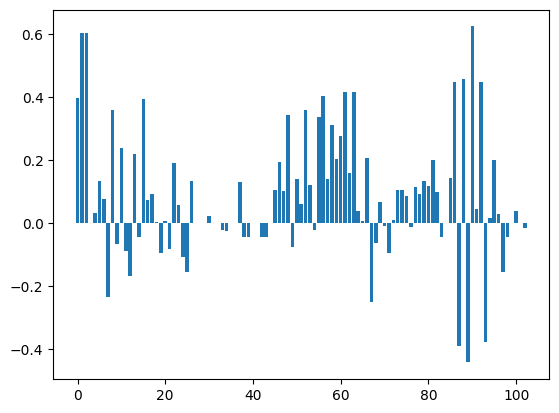

In [71]:
# Plotting the scores of the features
plt.bar([i for i in range(len(r_reg_selector.scores_))], r_reg_selector.scores_)
plt.show()

### f_regression

In [72]:
# Selecting features based on f_regression
f_reg_selector = SelectKBest(f_regression, k=num_feats)
f_reg_selector.fit(X_fs_train_non_scaled, y_fs_train)
f_reg_support = f_reg_selector.get_support()
f_reg_feature = X_fs_train_non_scaled.loc[:,f_reg_support].columns.tolist()
print(str(len(f_reg_feature)), 'selected features')

10 selected features


In [73]:
# Examining selected features
f_reg_feature

['Matches played',
 'Minutes played',
 'Accurate passes, %',
 'Lateral passes per 90',
 'Short / medium passes per 90',
 'Conceded goals',
 'Shots against',
 'Shots against per 90',
 'Clean sheets',
 'xG against']

In [74]:
# Examining the scores of the features
for i in range(len(f_reg_selector.scores_)):
 print('Feature %d: %f' % (i, f_reg_selector.scores_[i]))

Feature 0: 18.357268
Feature 1: 55.475803
Feature 2: 55.598828
Feature 3: 0.000000
Feature 4: 0.100064
Feature 5: 1.755022
Feature 6: 0.577475
Feature 7: 5.572828
Feature 8: 14.405809
Feature 9: 0.424429
Feature 10: 5.974100
Feature 11: 0.779395
Feature 12: 2.764041
Feature 13: 4.985794
Feature 14: 0.178048
Feature 15: 17.928881
Feature 16: 0.558046
Feature 17: 0.848889
Feature 18: 0.003021
Feature 19: 0.891791
Feature 20: 0.004250
Feature 21: 0.639116
Feature 22: 3.688318
Feature 23: 0.333149
Feature 24: 1.132547
Feature 25: 2.325341
Feature 26: 1.793591
Feature 27: 0.000000
Feature 28: 0.000000
Feature 29: 0.000000
Feature 30: 0.049368
Feature 31: 0.000000
Feature 32: 0.000000
Feature 33: 0.037022
Feature 34: 0.056152
Feature 35: 0.000000
Feature 36: 0.000000
Feature 37: 1.738832
Feature 38: 0.193731
Feature 39: 0.193731
Feature 40: 0.000000
Feature 41: 0.000000
Feature 42: 0.193731
Feature 43: 0.193731
Feature 44: 0.000000
Feature 45: 1.076920
Feature 46: 3.875156
Feature 47: 1.0398

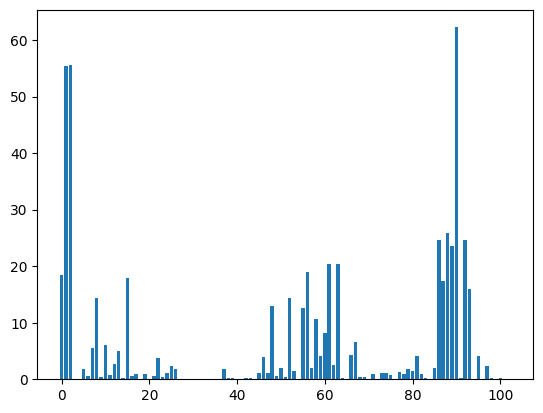

In [75]:
# Plotting the scores of the features
plt.bar([i for i in range(len(f_reg_selector.scores_))], f_reg_selector.scores_)
plt.show()

### mutual_info_regression

In [76]:
# Selecting features based on mutual_info_regression
mir_selector = SelectKBest(mutual_info_regression, k=num_feats)
mir_selector.fit(X_fs_train, y_fs_train)
mir_support = mir_selector.get_support()
mir_feature = X_fs_train.loc[:,mir_support].columns.tolist()
print(str(len(mir_feature)), 'selected features')

10 selected features


In [77]:
# Examining selected features
mir_feature

['Age',
 'Matches played',
 'Minutes played',
 'Interceptions per 90',
 'Lateral passes per 90',
 'Accurate passes to final third, %',
 'Passes to penalty area per 90',
 'Conceded goals',
 'Clean sheets',
 'xG against']

In [78]:
# Examining the scores of the features
for i in range(len(mir_selector.scores_)):
 print('Feature %d: %f' % (i, mir_selector.scores_[i]))

Feature 0: 0.403739
Feature 1: 0.266178
Feature 2: 0.255131
Feature 3: 0.002887
Feature 4: 0.005413
Feature 5: 0.000000
Feature 6: 0.000000
Feature 7: 0.130338
Feature 8: 0.058340
Feature 9: 0.146700
Feature 10: 0.085345
Feature 11: 0.133276
Feature 12: 0.172098
Feature 13: 0.148319
Feature 14: 0.075571
Feature 15: 0.161476
Feature 16: 0.000000
Feature 17: 0.008523
Feature 18: 0.000000
Feature 19: 0.250652
Feature 20: 0.207602
Feature 21: 0.016800
Feature 22: 0.073764
Feature 23: 0.144007
Feature 24: 0.001742
Feature 25: 0.002223
Feature 26: 0.060134
Feature 27: 0.002747
Feature 28: 0.000000
Feature 29: 0.002108
Feature 30: 0.000000
Feature 31: 0.000000
Feature 32: 0.000658
Feature 33: 0.001649
Feature 34: 0.003804
Feature 35: 0.000000
Feature 36: 0.002521
Feature 37: 0.000000
Feature 38: 0.000000
Feature 39: 0.003400
Feature 40: 0.000000
Feature 41: 0.002811
Feature 42: 0.005228
Feature 43: 0.002063
Feature 44: 0.001962
Feature 45: 0.037865
Feature 46: 0.014708
Feature 47: 0.202728
Fe

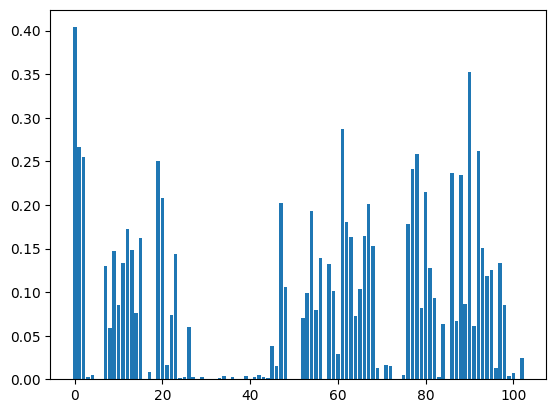

In [79]:
# Plotting the scores of the features
plt.bar([i for i in range(len(mir_selector.scores_))], mir_selector.scores_)
plt.show()

## Wrapper-based Methods (Recursive Feature Elimination)

### Recursive Feature Elimination

In [80]:
# Selecting features based on Recursive Feature Elimination
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_fs_train, y_fs_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_fs_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 103 features.
Fitting estimator with 93 features.
Fitting estimator with 83 features.
Fitting estimator with 73 features.
Fitting estimator with 63 features.
Fitting estimator with 53 features.
Fitting estimator with 43 features.
Fitting estimator with 33 features.
Fitting estimator with 23 features.
Fitting estimator with 13 features.
10 selected features


In [81]:
# Examining selected features
rfe_feature

['Assists',
 'xA',
 'Assists per 90',
 'Passes per 90',
 'Short / medium passes per 90',
 'Long passes per 90',
 'xA per 90',
 'Conceded goals per 90',
 'Shots against',
 'Prevented goals per 90']

In [82]:
# Examining the scores of the features
for i in range(len(rfe_selector.ranking_)):
 print('Feature %d: %f' % (i, rfe_selector.ranking_[i]))

Feature 0: 7.000000
Feature 1: 5.000000
Feature 2: 4.000000
Feature 3: 10.000000
Feature 4: 7.000000
Feature 5: 1.000000
Feature 6: 1.000000
Feature 7: 5.000000
Feature 8: 7.000000
Feature 9: 9.000000
Feature 10: 4.000000
Feature 11: 3.000000
Feature 12: 5.000000
Feature 13: 8.000000
Feature 14: 6.000000
Feature 15: 5.000000
Feature 16: 3.000000
Feature 17: 2.000000
Feature 18: 8.000000
Feature 19: 3.000000
Feature 20: 6.000000
Feature 21: 10.000000
Feature 22: 9.000000
Feature 23: 4.000000
Feature 24: 3.000000
Feature 25: 2.000000
Feature 26: 6.000000
Feature 27: 11.000000
Feature 28: 10.000000
Feature 29: 11.000000
Feature 30: 9.000000
Feature 31: 10.000000
Feature 32: 11.000000
Feature 33: 9.000000
Feature 34: 10.000000
Feature 35: 11.000000
Feature 36: 11.000000
Feature 37: 1.000000
Feature 38: 10.000000
Feature 39: 10.000000
Feature 40: 11.000000
Feature 41: 11.000000
Feature 42: 10.000000
Feature 43: 10.000000
Feature 44: 11.000000
Feature 45: 5.000000
Feature 46: 7.000000
Featur

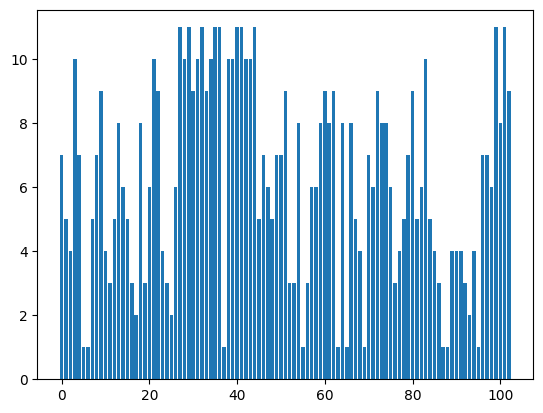

In [83]:
# Plotting the scores of the features
plt.bar([i for i in range(len(rfe_selector.ranking_))], rfe_selector.ranking_)
plt.show()

## Embedded Methods (SelectFromModel)

### Linear Regression: SelectFromModel

In [84]:
# Selecting features based on Linear Regression and SelectFromModel
embedded_lr_selector = SelectFromModel(LinearRegression(), max_features=num_feats)
embedded_lr_selector.fit(X_fs_train, y_fs_train)
embedded_lr_support = embedded_lr_selector.get_support()
embedded_lr_feature = X_fs_train.loc[:,embedded_lr_support].columns.tolist()
print(str(len(embedded_lr_feature)), 'selected features')

10 selected features


In [85]:
# Examining selected features
embedded_lr_feature

['xA',
 'Sliding tackles per 90',
 'Passes per 90',
 'Short / medium passes per 90',
 'Long passes per 90',
 'xA per 90',
 'Conceded goals per 90',
 'Shots against per 90',
 'xG against per 90',
 'Prevented goals per 90']

### Random Forest: SelectFromModel

In [86]:
# Selecting features based on Random Forest and SelectFromModel
embeded_rf_selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), max_features=num_feats)
embeded_rf_selector.fit(X_fs_train, y_fs_train)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_fs_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

10 selected features


In [87]:
# Examining selected features
embeded_rf_feature

['Age',
 'Matches played',
 'Minutes played',
 'PAdj Interceptions',
 'Accurate passes, %',
 'Accurate forward passes, %',
 'Lateral passes per 90',
 'Short / medium passes per 90',
 'Average pass length, m',
 'Clean sheets']

### XGB Regressor: SelectFromModel

In [88]:
# Selecting features based on XGB Regressor and SelectFromModel
embeded_xgb_selector = SelectFromModel(XGBRegressor(n_estimators=100, random_state=42), max_features=num_feats)
embeded_xgb_selector.fit(X_fs_train, y_fs_train)
embeded_xgb_support = embeded_xgb_selector.get_support()
embeded_xgb_feature = X_fs_train.loc[:,embeded_xgb_support].columns.tolist()
print(str(len(embeded_xgb_feature)), 'selected features')

10 selected features


In [89]:
# Examining selected features
embeded_xgb_feature

['Matches played',
 'Minutes played',
 'Red cards per 90',
 'Accurate passes, %',
 'Accurate forward passes, %',
 'Short / medium passes per 90',
 'Conceded goals per 90',
 'Shots against per 90',
 'Clean sheets',
 'xG against']

### LGBM Regressor: SelectFromModel

In [90]:
# Selecting features based on LGBM Regressor and SelectFromModel
embeded_lgbm_selector = SelectFromModel(LGBMRegressor(n_estimators=100, random_state=42), max_features=num_feats)
embeded_lgbm_selector.fit(X_fs_train_lgbm, y_fs_train)
embeded_lgbm_support = embeded_lgbm_selector.get_support()
embeded_lgbm_feature = X_fs_train.loc[:,embeded_lgbm_support].columns.tolist()
print(str(len(embeded_lgbm_feature)), 'selected features')

10 selected features


In [91]:
# Examining selected features
embeded_lgbm_feature

['Age',
 'Duels won, %',
 'Successful defensive actions per 90',
 'PAdj Interceptions',
 'Accurate passes, %',
 'Short / medium passes per 90',
 'Average pass length, m',
 'Shots against per 90',
 'Clean sheets',
 'xG against per 90']

## Feature Selection Overview

In [92]:
feature_name = list(X_fs_train.columns.values)

# put all selection together
feature_selection_df = pd.DataFrame({
    'Feature':feature_name, 
    'R Regression':r_reg_support, 
    'F Regression':f_reg_support, 
    'Mutual Info Regression':mir_support,
    'Recursive Feature Elimination':rfe_support, 
    'Linear Regression':embedded_lr_support,
    'Random Forest Regressor':embeded_rf_support,
    'XGB Regressor':embeded_xgb_support,
    'LGBM Regressor':embeded_lgbm_support
    })

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

# display the top num_feats
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Feature,R Regression,F Regression,Mutual Info Regression,Recursive Feature Elimination,Linear Regression,Random Forest Regressor,XGB Regressor,LGBM Regressor,Total
1,Short / medium passes per 90,True,True,False,True,True,True,True,True,7
2,Clean sheets,True,True,True,False,False,True,True,True,6
3,Minutes played,True,True,True,False,False,True,True,False,5
4,Matches played,True,True,True,False,False,True,True,False,5
5,"Accurate passes, %",True,True,False,False,False,True,True,True,5
6,xG against,True,True,True,False,False,False,True,False,4
7,Shots against per 90,False,True,False,False,True,False,True,True,4
8,Lateral passes per 90,True,True,True,False,False,True,False,False,4
9,Age,True,False,True,False,False,True,False,True,4
10,Shots against,True,True,False,True,False,False,False,False,3


## Feature Selection Function

In [93]:
# Defining a function for feature selection based on above
def feature_selection(X_fs_train, y_fs_train, num_feats):

    r_reg_selector = SelectKBest(r_regression, k=num_feats)
    r_reg_selector.fit(X_fs_train_non_scaled, y_fs_train)
    r_reg_support = r_reg_selector.get_support()
    
    f_reg_selector = SelectKBest(f_regression, k=num_feats)
    f_reg_selector.fit(X_fs_train_non_scaled, y_fs_train)
    f_reg_support = f_reg_selector.get_support()

    mir_selector = SelectKBest(mutual_info_regression, k=num_feats)
    mir_selector.fit(X_fs_train, y_fs_train)
    mir_support = mir_selector.get_support()

    rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_fs_train, y_fs_train)
    rfe_support = rfe_selector.get_support()

    embedded_lr_selector = SelectFromModel(LinearRegression(), max_features=num_feats)
    embedded_lr_selector.fit(X_fs_train, y_fs_train)
    embedded_lr_support = embedded_lr_selector.get_support()

    embeded_rf_selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), max_features=num_feats)
    embeded_rf_selector.fit(X_fs_train, y_fs_train)
    embeded_rf_support = embeded_rf_selector.get_support()

    embeded_xgb_selector = SelectFromModel(XGBRegressor(n_estimators=100, random_state=42), max_features=num_feats)
    embeded_xgb_selector.fit(X_fs_train, y_fs_train)
    embeded_xgb_support = embeded_xgb_selector.get_support()
    
    embeded_lgbm_selector = SelectFromModel(LGBMRegressor(n_estimators=100, random_state=42), max_features=num_feats)
    embeded_lgbm_selector.fit(X_fs_train_lgbm, y_fs_train)
    embeded_lgbm_support = embeded_lgbm_selector.get_support()
        
    
    feature_name = list(X_fs_train.columns.values)

    # put all selection together
    feature_selection_df = pd.DataFrame({
    'Feature':feature_name,
    'R Regression':r_reg_support,
    'F Regression':f_reg_support,
    'Mutual Info Regression':mir_support,
    'Recursive Feature Elimination':rfe_support,
    'Linear Regression':embedded_lr_support,
    'Random Forest Regressor':embeded_rf_support,
    'XGB Regressor':embeded_xgb_support,
    'LGBM Regressor':embeded_lgbm_support
    })

    # count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

    # display the top num_feats
    feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df)+1)

    return feature_selection_df.head(num_feats)

# Modeling 

Applying multiple regression models to select the best performing model

In [94]:
# Creating a function to print model scores
def model_scores(model, X_train, y_train):
    model_name = type(model).__name__
    Score = model.score(X_train, y_train).round(3)
    MSE = mean_squared_error(y_train, model.predict(X_train), squared=True).round(2)
    RMSE = mean_squared_error(y_train, model.predict(X_train), squared=False).round(2)
    MAE = mean_absolute_error(y_train, model.predict(X_train)).round(2)
    dataframe = pd.DataFrame({'Score': [Score], 'MSE': [MSE], 'RMSE': [RMSE], 'MAE': [MAE]}, index=[model_name])
    return print(dataframe)

## Modeling ***without*** Feature Selection

In [95]:
# Instantiating the models without feature selection
model_lr_wo_fs = LinearRegression()
model_rf_wo_fs = RandomForestRegressor(random_state=42)
model_xgb_wo_fs = XGBRegressor(random_state=42)
model_lgbm_wo_fs = LGBMRegressor(random_state=42)

In [96]:
# Fitting the models without feature selection
model_lr_wo_fs.fit(X_fs_train, y_fs_train)
model_rf_wo_fs.fit(X_fs_train, y_fs_train)
model_xgb_wo_fs.fit(X_fs_train, y_fs_train)
model_lgbm_wo_fs.fit(X_fs_train_lgbm, y_fs_train)

In [ ]:
# Printing model scores on training data
model_scores(model_lr_wo_fs, X_fs_train, y_fs_train)
print('')
model_scores(model_rf_wo_fs, X_fs_train, y_fs_train)
print('')
model_scores(model_xgb_wo_fs, X_fs_train, y_fs_train)
print('')
model_scores(model_lgbm_wo_fs, X_fs_train, y_fs_train)

                  Score   MSE  RMSE   MAE
LinearRegression  0.991  0.34  0.59  0.31

                       Score   MSE  RMSE   MAE
RandomForestRegressor  0.944  2.02  1.42  1.06

              Score   MSE  RMSE   MAE
XGBRegressor  0.993  0.25   0.5  0.16

               Score   MSE  RMSE   MAE
LGBMRegressor   0.94  2.18  1.48  1.06


In [ ]:
# Printing model scores on test data
model_scores(model_lr_wo_fs, X_fs_test, y_fs_test)
print('')
model_scores(model_rf_wo_fs, X_fs_test, y_fs_test)
print('')
model_scores(model_xgb_wo_fs, X_fs_test, y_fs_test)
print('')
model_scores(model_lgbm_wo_fs, X_fs_test, y_fs_test)

                    Score      MSE   RMSE    MAE
LinearRegression -141.717  8266.18  90.92  68.41

                       Score    MSE  RMSE   MAE
RandomForestRegressor  0.599  23.21  4.82  3.48

              Score    MSE  RMSE   MAE
XGBRegressor  0.612  22.45  4.74  3.76

               Score    MSE  RMSE   MAE
LGBMRegressor  0.616  22.26  4.72  3.55


## Data Preparation ***with*** Feature Selection

In [15]:
# Extracting the rating and top 10 features identified during feature selection by using the feature selection function
model_df = pd.merge(df_GK[feature_selection(X_fs_train, y_fs_train, 10).Feature.values.tolist()], pd.DataFrame(df_GK['Rating']), left_index=True, right_index=True)

NameError: name 'df_GK' is not defined

In [16]:
# Examining the selected features
model_df

NameError: name 'model_df' is not defined

In [80]:
# Defining X by dropping the target value y
X = model_df.drop(['Rating'], axis=1)

In [81]:
# Defining the target value y
y = model_df['Rating']

In [82]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Summarizing the split
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (99, 10) (99,)
Test (25, 10) (25,)


In [83]:
# Scaling X_train and X_test
# Instantiating the scaler to save it later for streamlit
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)

In [84]:
# Renaming special JSON characters in feature names so LGBM can read it
X_train_lgbm = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

## Modeling ***with*** Feature Selection

In [85]:
# Instantiating the models with feature selection
model_lr_w_fs = LinearRegression()
model_rf_w_fs = RandomForestRegressor(random_state=42)
model_xgb_w_fs = XGBRegressor(random_state=42)
model_lgbm_w_fs = LGBMRegressor(random_state=42)

In [86]:
# Fitting the models with feature selection
model_lr_w_fs.fit(X_train, y_train)
model_rf_w_fs.fit(X_train, y_train)
model_xgb_w_fs.fit(X_train, y_train)
model_lgbm_w_fs.fit(X_train_lgbm, y_train)

LGBMRegressor(random_state=42)

In [87]:
# Printing model scores on training data
model_scores(model_lr_w_fs, X_train, y_train)
print('')
model_scores(model_rf_w_fs, X_train, y_train)
print('')
model_scores(model_xgb_w_fs, X_train, y_train)
print('')
model_scores(model_lgbm_w_fs, X_train, y_train)


                  Score    MSE  RMSE   MAE
LinearRegression  0.703  10.82  3.29  2.64

                       Score   MSE  RMSE   MAE
RandomForestRegressor  0.946  1.95   1.4  1.01

              Score   MSE  RMSE   MAE
XGBRegressor  0.993  0.26  0.51  0.17

               Score   MSE  RMSE   MAE
LGBMRegressor  0.873  4.64  2.15  1.56


In [88]:
# Printing model scores on test data
model_scores(model_lr_w_fs, X_test, y_test)
print('')
model_scores(model_rf_w_fs, X_test, y_test)
print('')
model_scores(model_xgb_w_fs, X_test, y_test)
print('')
model_scores(model_lgbm_w_fs, X_test, y_test)

                  Score    MSE  RMSE   MAE
LinearRegression  0.726  15.87  3.98  3.16

                       Score    MSE  RMSE   MAE
RandomForestRegressor  0.676  18.76  4.33  3.31

              Score    MSE  RMSE   MAE
XGBRegressor  0.607  22.75  4.77  3.54

               Score    MSE  RMSE   MAE
LGBMRegressor  0.733  15.45  3.93  3.07


## Hyperparameter tuning

Performing hyperparameter tuning by means of GridSearchCV and 5-fold crossvalidation

### Random Forest Regressor

In [ ]:
# Defining the model and parameters
model_rf = RandomForestRegressor()
grid_rf =   {'bootstrap': [True, False],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [25, 50]}

# Performing grid search on the model using 'scorer' as the scoring method
grid_search = GridSearchCV(estimator=model_rf, param_grid=grid_rf, scoring=scorer, cv=5)
grid_result = grid_search.fit(X_train, y_train)

# Identifying the best estimator
opt_params = grid_result.best_estimator_
print('Optimal parameters: ' + str(opt_params))

# Fitting the model with the optimal parameters
opt_params.fit(X_train, y_train)

# Model performance on training data
print('Model performance on traning data with optimal parameters: ' + str(opt_params.score(X_train, y_train)))


# Model performance on test data

print('Model performance on test data with optimal parameters: ' + str(opt_params.score(X_test, y_test)))

### XGB Regressor

In [ ]:
# Defining the model and parameters
n_estimators = [100,200, 500, 900]
max_depth = [2, 3, 5, 10]
learning_rate = [0.05, 0.1, 0.15, 0.20]
gamma = [0.01, 0.1]

model_xgb = XGBRegressor()
grid_xgb = {"n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "gamma": gamma
            }

GS = GridSearchCV(estimator=model_xgb, param_grid=grid_xgb, scoring=["r2", "neg_root_mean_squared_error"], refit="r2", cv=5, verbose=4)
GS.fit(X_train, y_train)

# Performing grid search on the model using 'scorer' as the scoring method
grid_search = GridSearchCV(estimator=model_xgb, param_grid=grid_xgb, scoring=scorer, cv=5)
grid_result = grid_search.fit(X_train, y_train)

# Identifying the best estimator
opt_params = grid_result.best_estimator_
print('Optimal parameters: ' + str(opt_params))

#Fitting the model with the optimal parameters
opt_params.fit(X_train, y_train)

# Model performance on training data
print('Model performance on traning data with optimal parameters: ' + str(opt_params.score(X_train, y_train)))


# Model performance on test data
print('Model performance on test data with optimal parameters: ' + str(opt_params.score(X_test, y_test)))


### LGBM Regressor

In [ ]:
# define the range of hyperparameters 
params_lgbm = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'num_leaves': [10, 50, 100],
    'min_child_weight': [0.1, 1, 10],
    'min_sum_hessian_in_leaf': [0.01, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1],
}

# create the LightGBM model
model_lgbm = LGBMRegressor()

# use grid search to evaluate the model for each combination of hyperparameters
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model_lgbm, param_grid=params_lgbm, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train_lgbm, y_train)

# print the best hyperparameters found by grid search
print(grid.best_params_)


# Identifying the best estimator
opt_params = grid_result.best_estimator_
print('Optimal parameters: ' + str(opt_params))

# Fitting the model with the optimal parameters
opt_params.fit(X_train_lgbm, y_train)

# Model performance on training data
print('Model performance on traning data with optimal parameters: ' + str(opt_params.score(X_train, y_train)))


# Model performance on test data
print('Model performance on test data with optimal parameters: ' + str(opt_params.score(X_test, y_test)))

## Further Exploration of the Best Performing Model (SHAP)

Once the best performing model is identified, it is explored in SHAP

The best performing model for goalkeepers is the LGBM Regressor with feature selection at a score of 0.733 (model_lgbm_w_fs). 

In [89]:
# Defining the best perfming model based on model_scores above
model = model_lgbm_w_fs

In [90]:
# Defining the SHAP explainer
explainer = shap.TreeExplainer(model)

In [91]:
# Defining the SHAP values
shap_values = explainer.shap_values(X_train)

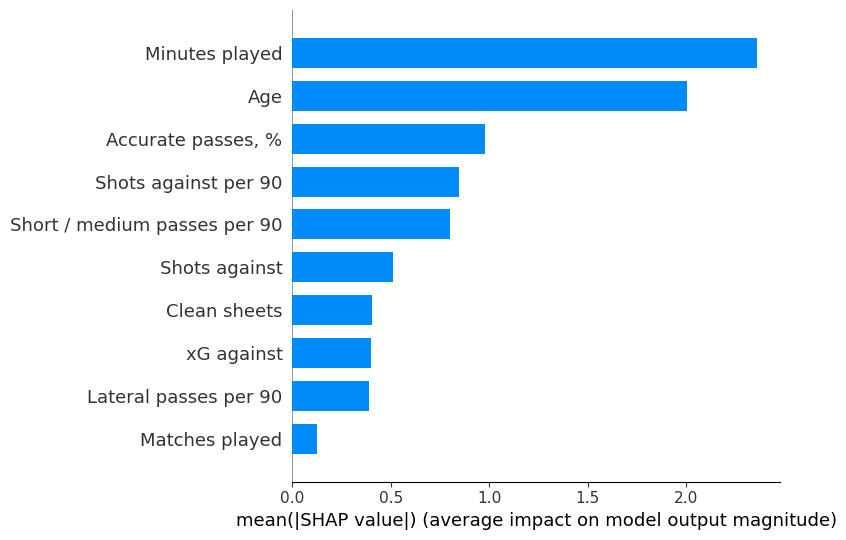

In [92]:
# Plotting a SHAP summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

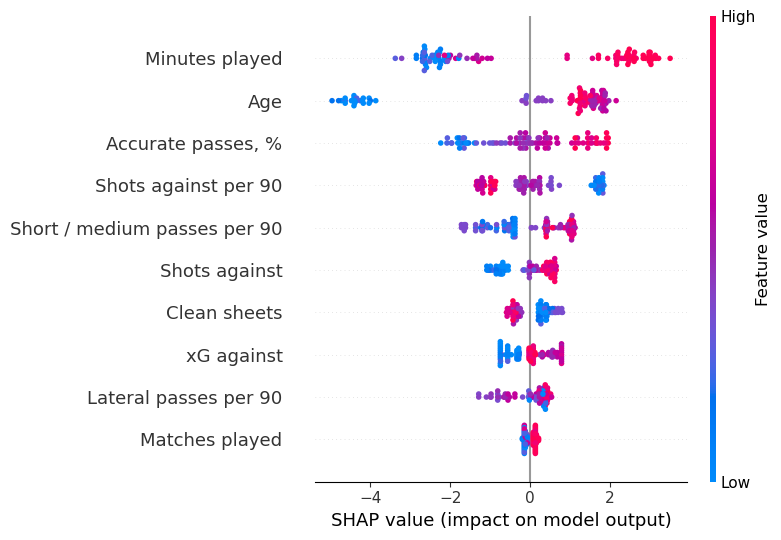

In [93]:
# Plotting a SHAP summary plot
shap.summary_plot(shap_values, X_train)

In [94]:
# Plotting a SHAP force plot on row 1 as an example to identify how features affect the prediction of the rating
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_train.iloc[1,:])

In [95]:
# Displaying y to see the actual value of the prediction (77.09 predicted vs. 83 actual)
y.head()

0    92
1    83
2    83
3    83
4    82
Name: Rating, dtype: int64

# Pickling the Content

In [48]:
# Defining rmse of the best performing model to be saved for streamlit
rmse = mean_squared_error(y_test, model.predict(X_test), squared=False).round(2)

# Saving the model, scaler, shap values and rmse for streamlit
pickle.dump(model, open('GK_model.pkl','wb'))
pickle.dump(scaler, open('GK_scaler.pkl','wb'))
pickle.dump(shap_values, open('GK_shap.pkl','wb'))
pickle.dump(rmse, open('GK_rmse.pkl','wb'))

# Saving the selected features for each subset of positions as a CSV for Streamlit
features_selected = X.columns.values.tolist()
features_selected = pd.DataFrame(features_selected, columns=["Feature"])
features_selected.to_csv('GK_fs.csv', index=False)

# Report Illustrations

In [ ]:
# Setting plot size
plt.rcParams["figure.figsize"] = (5,5)

# Merging datasets for illustration purposes
BL_18 = BL18.dropna(axis = 1)
BL_18_20 = pd.concat([BL18, BL19, BL20]).reset_index(drop=True)
BL_18_22 = pd.concat([BL18, BL19, BL20, BL21, BL22]).reset_index(drop=True)

# Define x and y values for linear regression
x_18 = BL_18['Minutes played'].array.reshape(-1, 1)
y_18 = BL_18['Rating']
x_18_20 = BL_18_20['Minutes played'].array.reshape(-1, 1)
y_18_20 = BL_18_20['Rating']
x_18_22 = BL_18_22['Minutes played'].array.reshape(-1, 1)
y_18_22 = BL_18_22['Rating']

# Regression plot
def plot(x, y , predicted):
    plt.scatter(x, y, color='black')
    plt.plot(x, predicted,'blue')
    plt.title('Bundesliga year, coefficient score: ' + str(model.fit(x, y).score(x, y).round(2)))
    plt.xlabel('Minutes played')
    plt.ylabel('Rating')
    plt.show()

# Fit regression model
model = LinearRegression()

# Fit with 2018 data and plot
model.fit(x_18, y_18)
predicted_18 = model.predict(x_18)
plot(x_18, y_18, predicted_18)


# Fit with 2018-2019 data and plot
model.fit(x_18_20, y_18_20)
predicted_18_20 = model.predict(x_18_20)
plot(x_18_20, y_18_20, predicted_18_20)


# Fit with 2018-2022 data and plot
model.fit(x_18_22, y_18_22)
predicted_18_22 = model.predict(x_18_22)
plot(x_18_22, y_18_22, predicted_18_22)

In [ ]:
import seaborn as sns

#sns.displot(BL_18_22, x="Fouls per 90", kind="kde")
sns.displot(BL_18_22, x="Duels won, %", kind="kde", color='blue')
sns.displot(BL_18_22, x="Aerial duels per 90", kind="kde", color='blue')
sns.displot(BL_18_22, x="Average pass length, m", kind="kde", color='blue')